In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import holoviews as hv
# hv.extension('bokeh')
import hvplot.xarray
import hvplot.pandas
from bokeh.models import DatetimeTickFormatter, FixedTicker, TickFormatter

import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import whenever 
import glob
import os
import pytz
from timezonefinder import TimezoneFinder


In [2]:
## Note: if cfeatures do not work, download manually to directory: 
# import cartopy 
# print(cartopy.config['data_dir'])

In [3]:
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

In [4]:
proj=ccrs.PlateCarree()

In [5]:
# Import site metadata csv
filepath = 'ameriflux-data/'
meta_file = filepath + 'AmeriFlux-site-search-results-202410071335.tsv'
ameriflux_meta = pd.read_csv(meta_file, sep='\t')
fluxnet_meta = ameriflux_meta.loc[ameriflux_meta['AmeriFlux FLUXNET Data'] == 'Yes'] #use FLUXNET only
# fluxnet_simple = fluxnet_meta[['Site ID', 'Longitude (degrees)', 'Latitude (degrees)', 'Years of AmeriFlux FLUXNET Data']] #drop unneeded columns

In [6]:
# Example sites of varying geography
site_list = ['US-A32', 'US-Bar', 'US-RGB', 'US-xJE', 'US-SRC']
sites_meta = ameriflux_meta.loc[ameriflux_meta['Site ID'].isin(site_list)]
sites_meta

,Site ID,Name,Principal Investigator,Data Use Policy,AmeriFlux BASE Data,AmeriFlux FLUXNET Data,Vegetation Abbreviation (IGBP),Vegetation Description (IGBP),Climate Class Abbreviation (Koeppen),Climate Class Description (Koeppen),...,Longitude (degrees),Elevation (m),Years of AmeriFlux BASE Data,AmeriFlux BASE DOI,Years of AmeriFlux FLUXNET Data,AmeriFlux FLUXNET DOI,Site Start,Site End,BASE variables available,FLUXNET variables available
133,US-A32,ARM-SGP Medford hay pasture,Sebastien Biraud (scbiraud@lbl.gov),CC-BY-4.0,Yes,Yes,GRA,Grasslands: Lands with herbaceous types of cov...,Cfa,"Humid Subtropical: mild with no dry season, ho...",...,-97.8198,335.0,"2015, 2016, 2017",https://doi.org/10.17190/AMF/1436327,"2015, 2016, 2017",https://doi.org/10.17190/AMF/1881568,2015.0,2017.0,"ALB, CO2, FC, G, H, H2O, LE, LW_IN, LW_OUT, ND...",NaN
157,US-Bar,Bartlett Experimental Forest,Andrew Richardson (Andrew.Richardson@nau.edu),CC-BY-4.0,Yes,Yes,DBF,Deciduous Broadleaf Forests: Lands dominated b...,Dfb,Warm Summer Continental: significant precipita...,...,-71.2881,272.0,"2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011...",https://doi.org/10.17190/AMF/1246030,"2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011...",https://doi.org/10.17190/AMF/2006969,2004.0,NaN,"CO2, FC, H, LE, NETRAD, P, PA, PPFD_BC_IN, PPF...",NaN
477,US-RGB,Butte County Rice Farm,Sebastien C. Biraud (SCBiraud@lbl.gov),CC-BY-4.0,Yes,Yes,CRO,Croplands: Lands covered with temporary crops ...,Csa,"Mediterranean: mild with dry, hot summer",...,-121.8579,33.0,"2021, 2022, 2023",https://doi.org/10.17190/AMF/1870591,2021,https://doi.org/10.17190/AMF/2204874,2021.0,NaN,"CO2, FC, FC_SSITC_TEST, FETCH_70, FETCH_80, FE...",NaN
530,US-SRC,Santa Rita Creosote,Shirley (Kurc) Papuga (shirley.papuga@gmail.com),CC-BY-4.0,Yes,Yes,OSH,Open Shrublands: Lands with woody vegetation l...,Bwh,Desert: warm winter,...,-110.8395,950.0,"2008, 2009, 2010, 2011, 2012, 2013, 2014",https://doi.org/10.17190/AMF/1246127,"2008, 2009, 2010, 2011, 2012, 2013, 2014",https://doi.org/10.17190/AMF/1871145,2008.0,2018.0,"CO2, FC, G, H, H2O, LE, LW_IN, LW_OUT, NETRAD,...",NaN
640,US-xJE,NEON Jones Ecological Research Center (JERC),National Ecological Observatory Network (neon-...,CC-BY-4.0,Yes,Yes,ENF,Evergreen Needleleaf Forests: Lands dominated ...,Cfa,"Humid Subtropical: mild with no dry season, ho...",...,-84.4686,44.0,"2017, 2018, 2019, 2020, 2021, 2022, 2023",https://doi.org/10.17190/AMF/1617730,"2017, 2018, 2019, 2020, 2021",https://doi.org/10.17190/AMF/1985443,2017.0,NaN,"CH4, CH4_MIXING_RATIO, CO2, CO2C13, CO2_MIXING...",NaN


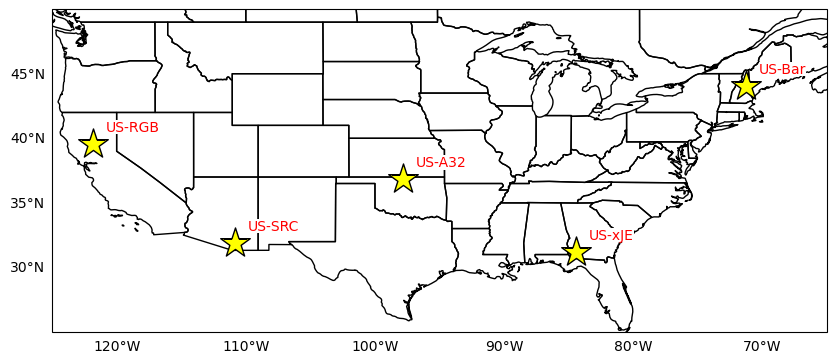

In [7]:
# Plot sites
# subset CONUS
min_lon, max_lon = -125, -65
min_lat, max_lat = 25, 50

fig, ax = plt.subplots(figsize=(10,6),subplot_kw= {'projection': proj});
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=proj);
ax.add_feature(cfeature.STATES)

for site_ID in site_list:
    site_lat = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
    site_lon = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

    ax.scatter(site_lon,site_lat,
           marker='*', 
           s=500,
           color='yellow',
           edgecolor='black', zorder=3)
    ax.annotate(site_ID, (site_lon + 1,site_lat+1),
                color='red',
                bbox=dict(facecolor='white',edgecolor='None', pad=0.1,
                         )
                         
               )
    

# ax.legend(loc='lower left')
gl = ax.gridlines(draw_labels=True,x_inline=False, y_inline=False,color = "None")
gl.top_labels = False
gl.right_labels = False

In [9]:
timedelta = 'DD'

In [10]:
filepath = 'ameriflux-data/'
sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')
fluxnet_sel = pd.read_csv(sel_file)

# select subset of columns + convert to datetime objects    
fluxnet_sel_simple = fluxnet_sel.loc[:,['TIMESTAMP','NEE_VUT_REF']].copy()
fluxnet_sel_simple['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_simple['TIMESTAMP'],format='%Y%m%d')
fluxnet_sel_simple = fluxnet_sel_simple.set_index('TIMESTAMP')

# # Convert time zone (Fluxnet reported in local standard time)
# fluxnet_sel_simple = local_std_to_utc_std(fluxnet_sel_simple,'TIMESTAMP_START',site_lat, site_lon)
# fluxnet_sel_simple = fluxnet_sel_simple.set_index('utc_time')

# Convert units
# FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
fluxnet_sel_final = fluxnet_sel_simple['NEE_VUT_REF']*1e-6*12.01*1e-3
fluxnet_sel_final.name = 'FluxNET NEE (kgC m-2 s-1)'
# fluxnet_sel_final

In [11]:
# Function to obtain location data
def get_loc_data(site_ID):
    
    ## Fluxnet Data 
    # Import selected site daily subset data
    timedelta = 'DD'
    
    site_lat = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
    site_lon = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

    filepath = 'ameriflux-data/'
    sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')
    fluxnet_sel = pd.read_csv(sel_file)

    # select subset of columns + convert to datetime objects    
    fluxnet_sel_simple = fluxnet_sel.loc[:,['TIMESTAMP','NEE_VUT_REF']].copy()
    fluxnet_sel_simple['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_simple['TIMESTAMP'],format='%Y%m%d')
    fluxnet_sel_simple = fluxnet_sel_simple.set_index('TIMESTAMP')


    # Convert units
    # FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
    fluxnet_sel_final = fluxnet_sel_simple['NEE_VUT_REF']*1e-6*12.01*1e-3
    fluxnet_sel_final.name = 'FluxNET NEE (kgC m-2 s-1)'

    # Import MiCASA from data-extract.py
    dir = 'output'
    filename = f'{site_ID}_micasa_{timedelta}.csv'
    path = os.path.join(dir, filename)
    micasa_ds = pd.read_csv(path,index_col=0)
    micasa_ds.index = pd.to_datetime(micasa_ds.index)
    

    # Create datetime index and specify UTC
    # micasa_ds.index = micasa_ds.index.tz_localize('UTC')
    # micasa_ds.index.name = 'utc_time'

    # Append together
    plot_ds = micasa_ds.merge(fluxnet_sel_final,left_index=True, right_index=True)
    return plot_ds

In [12]:
# Function to plot data
def hv_plot_data(dataset):
    # Define misc plotting variables
    datetimeformatter = DatetimeTickFormatter(
    hours='%H:%M',
    days='%m/%d %H:%M',
    months='%b %Y',
    )
    # months='%b %Y %H:%M')
    
    plot = dataset.hvplot(
        kind='line',
        width=1300, height=400,
        groupby=['time.year'],
        # groupby=['time.year', 'time.month'],
        widget_location='bottom',
        # xaxis={'ticker':FixedTicker(ticks=[i*6*3600*1000 for i in range(24)])},
        xformatter= datetimeformatter,
        yformatter='%.1e',
        ylabel = 'NEE (kg C m-2 s-1)',
        title = f'{site_ID} (Daily Averages)',
        legend='bottom',
        grid=True,
    )    
    return plot

In [13]:
# Define subset site info to display
site_subset = ['Site ID', 
                'Name', 
                'Vegetation Description (IGBP)', 
                'Climate Class Description (Koeppen)', 
                'Elevation (m)',
                'Years of AmeriFlux FLUXNET Data']

# Testing QC

In [14]:
timedelta = 'DD'
site_ID =  'US-A32'

In [15]:
# Import micasa
dir = 'output'
filename = f'{site_ID}_micasa_{timedelta}.csv'
path = os.path.join(dir, filename)
micasa_ds = pd.read_csv(path,index_col=0)
micasa_ds.index = pd.to_datetime(micasa_ds.index)
micasa_ds

,MiCASA NEE (kgC m-2 s-1)
time,
2015-01-01,2.470413e-09
2015-01-02,2.384823e-09
2015-01-03,2.041245e-09
2015-01-04,2.496862e-09
2015-01-05,2.620400e-09
...,...
2017-12-27,4.113398e-09
2017-12-28,4.242795e-09
2017-12-29,4.343825e-09


In [20]:
#import fluxnet
site_lat = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
site_lon = sites_meta.loc[sites_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

filepath = 'ameriflux-data/'
sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')

fluxnet_sel = pd.read_csv(sel_file)

# select subset of columns + convert to datetime objects    
fluxnet_sel_simple = fluxnet_sel.loc[:,['TIMESTAMP','NEE_VUT_REF','NEE_VUT_REF_QC']].copy()
fluxnet_sel_simple['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_simple['TIMESTAMP'],format='%Y%m%d')
fluxnet_sel_simple = fluxnet_sel_simple.set_index('TIMESTAMP')

# Convert units
# FluxNet NEE_VUT_REF (umolCO2 m-2 s-1) to MiCASA (kgC m-2 s-1)
fluxnet_sel_final = fluxnet_sel_simple.copy()
fluxnet_sel_final['NEE_VUT_REF'] = fluxnet_sel_simple['NEE_VUT_REF']*1e-6*12.01*1e-3
fluxnet_sel_final.name = 'FluxNET NEE (kgC m-2 s-1)'

In [21]:
# Quality flag for NEE_VUT_REF: fraction between 0-1, indicating percentage of measured and good quality gapfill data
# Note that this is different from the quality flag for the HH data
fluxnet_sel_final


,NEE_VUT_REF,NEE_VUT_REF_QC
TIMESTAMP,,
2015-01-01,-5.280401e-08,0.0
2015-01-02,-5.318448e-08,0.0
2015-01-03,-3.974517e-08,0.0
2015-01-04,-5.280401e-08,0.0
2015-01-05,-5.318448e-08,0.0
...,...,...
2017-12-27,-8.463891e-09,0.0
2017-12-28,-2.200148e-09,0.0
2017-12-29,1.293837e-08,0.0


In [22]:
fluxnet_sel_final.hvplot(kind='scatter',
                         x='TIMESTAMP',y='NEE_VUT_REF', c='NEE_VUT_REF_QC',
                         cmap = 'bmy', 
                         clabel='% of measured and good quality data',
                        # groupby=['TIMESTAMP.year'],
                        # widget_location='bottom',
                         width=1000, height=400,
                         title='Raw FluxNET Daily',
                         xlabel='time',
                        ylabel = 'NEE (kg C m-2 s-1)',
                         
                     )

:Scatter   [TIMESTAMP]   (NEE_VUT_REF,NEE_VUT_REF_QC)

In [64]:
# Set all values not 1 as NaN
fluxnet_sel_QC0 = fluxnet_sel_final.copy()
fluxnet_sel_QC0['NEE_VUT_REF'] = fluxnet_sel_QC0['NEE_VUT_REF'].mask(fluxnet_sel_QC0['NEE_VUT_REF_QC'] < 1, np.nan)
fluxnet_sel_QC0

,NEE_VUT_REF,NEE_VUT_REF_QC
TIMESTAMP,,
2015-01-01,NaN,0.0
2015-01-02,NaN,0.0
2015-01-03,NaN,0.0
2015-01-04,NaN,0.0
2015-01-05,NaN,0.0
...,...,...
2017-12-27,NaN,0.0
2017-12-28,NaN,0.0
2017-12-29,NaN,0.0


In [74]:
plot1 = fluxnet_sel_QC0['NEE_VUT_REF'].hvplot(
                        # kind='scatter',
                        c='red',
                        # groupby=['TIMESTAMP.year'],
                        # widget_location='bottom',
                       width=1200,height=500,
                       label='Fluxnet',
                         xlabel='time',
                        ylabel = 'NEE (kg C m-2 s-1)',
)

In [75]:
plot2 = micasa_ds.hvplot(label='MiCASA',
                         # groupby=['time.year']
                         c='skyblue'
                        )

In [76]:
plot1 * plot2 

:Overlay
   .Curve.Fluxnet :Curve   [TIMESTAMP]   (NEE_VUT_REF)
   .Curve.MiCASA  :Curve   [time]   (MiCASA NEE (kgC m-2 s-1))

# US-A32

In [39]:
site_ID =  'US-A32'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
133,US-A32,ARM-SGP Medford hay pasture,"Grasslands: Lands with herbaceous types of cover. Tree and shrub cover is less than 10%. Permanent wetlands lands with a permanent mixture of water and herbaceous or woody vegetation. The vegetation can be present in either salt, brackish, or fresh water.","Humid Subtropical: mild with no dry season, hot summer",335.0,"2015, 2016, 2017"


In [40]:
A32_data = get_loc_data(site_ID)
A32_data

,MiCASA NEE (kgC m-2 s-1),FluxNET NEE (kgC m-2 s-1)
time,,
2015-01-01,2.470413e-09,-5.280401e-08
2015-01-02,2.384823e-09,-5.318448e-08
2015-01-03,2.041245e-09,-3.974517e-08
2015-01-04,2.496862e-09,-5.280401e-08
2015-01-05,2.620400e-09,-5.318448e-08
...,...,...
2017-12-27,4.113398e-09,-8.463891e-09
2017-12-28,4.242795e-09,-2.200148e-09
2017-12-29,4.343825e-09,1.293837e-08


In [41]:
hv_plot_data(A32_data)

Column
    [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', widget_location='bottom', width=1300)
    [1] WidgetBox(align=('center', 'end'))
        [0] DiscreteSlider(name='time.year', options={'2015': np.int32(2015), ...}, value=np.int32(2015))

# US-RGB

In [42]:
site_ID =  'US-RGB'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
477,US-RGB,Butte County Rice Farm,"Croplands: Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type.","Mediterranean: mild with dry, hot summer",33.0,2021


In [43]:
RGB_data = get_loc_data(site_ID)

In [44]:
hv_plot_data(RGB_data)

Column
    [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', widget_location='bottom', width=1300)
    [1] WidgetBox(align=('center', 'end'))
        [0] Select(name='time.year', options=[np.int32(2021)], value=np.int32(2021))

# US-Bar

In [45]:
site_ID =  'US-Bar'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
157,US-Bar,Bartlett Experimental Forest,Deciduous Broadleaf Forests: Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Consists of broadleaf tree communities with an annual cycle of leaf-on and leaf-off periods.,Warm Summer Continental: significant precipitation in all seasons,272.0,"2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021"


In [46]:
Bar_data = get_loc_data(site_ID)

In [47]:
hv_plot_data(Bar_data)

Column
    [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', widget_location='bottom', width=1300)
    [1] WidgetBox(align=('center', 'end'))
        [0] DiscreteSlider(name='time.year', options={'2004': np.int32(2004), ...}, value=np.int32(2004))

# US-xJE

In [48]:
site_ID =  'US-xJE'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
640,US-xJE,NEON Jones Ecological Research Center (JERC),Evergreen Needleleaf Forests: Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees remain green all year. Canopy is never without green foliage.,"Humid Subtropical: mild with no dry season, hot summer",44.0,"2017, 2018, 2019, 2020, 2021"


In [49]:
xJE_data = get_loc_data(site_ID)

In [50]:
hv_plot_data(xJE_data)

Column
    [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', widget_location='bottom', width=1300)
    [1] WidgetBox(align=('center', 'end'))
        [0] DiscreteSlider(name='time.year', options={'2017': np.int32(2017), ...}, value=np.int32(2017))

# US-SRC

In [25]:
site_ID =  'US-SRC'
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
530,US-SRC,Santa Rita Creosote,Open Shrublands: Lands with woody vegetation less than 2 meters tall and with shrub canopy cover between 10-60%. The shrub foliage can be either evergreen or deciduous.,Desert: warm winter,950.0,"2008, 2009, 2010, 2011, 2012, 2013, 2014"


In [26]:
SRC_data = get_loc_data(site_ID)

In [27]:
hv_plot_data(SRC_data)

Column
    [0] HoloViews(DynamicMap, height=400, sizing_mode='fixed', widget_location='bottom', width=1300)
    [1] WidgetBox(align=('center', 'end'))
        [0] DiscreteSlider(name='time.year', options={'2008': np.int32(2008), ...}, value=np.int32(2008))
        [1] DiscreteSlider(name='time.month', options={'1': np.int32(1), ...}, value=np.int32(1))

# Dump

In [37]:
# ds = hv.Dataset(fluxnet_sel_final)
# hv.Scatter(data=ds, kdims=['TIMESTAMP'],vdims=['NEE_VUT_REF','NEE_VUT_REF_QC']).opts(color='NEE_VUT_REF_QC', width=1700, height=500, legend_position='bottom_right')

# hv.Dataset(fluxnet_sel_final).to(hv.Scatter, 'TIMESTAMP','NEE_VUT_REF').overlay('NEE_VUT_REF_QC').opts(width=1200, height=500)

# ds = hv.Dataset(fluxnet_sel_final)
# hv.Scatter(
    # data=ds, kdims=['TIMESTAMP'], vdims=['NEE_VUT_REF', 'NEE_VUT_REF_QC'],
# ).opts(color='NEE_VUT_REF_QC')

In [81]:
# fluxnet_sel_QC = fluxnet_sel_final.loc[fluxnet_sel_final['NEE_VUT_REF_QC'] !=0]
# fluxnet_sel_QC